In [1]:
# import matplotlib
# matplotlib.use('Agg')
import sys
sys.path.append('../')
import json
import string
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from os import remove
from pprint import pprint
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import keras.backend as K
from gensim.models import KeyedVectors
import word2vecReader as godin_embedding
import fasttext
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from base_learners import cnn,lstm,bi_lstm,cnn_bi_lstm,cnn_lstm
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12,10]
from mlens.visualization import corrmat
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
[MLENS] backend: threading


In [2]:
def load_data_from_file(filename):
    with open(filename,'r', errors='ignore') as fin:
        lines = fin.readlines()
    label = [int(x.split()[0]) for x in lines]
    sentence = [' '.join(x.split()[1:]) for x in lines]
    return label,sentence

In [3]:
train_labels,train_sentences = load_data_from_file('dataset/sst1/stsa.fine.train')
dev_label,dev_sentence = load_data_from_file('dataset/sst1/stsa.fine.dev')
test_labels,test_sentences = load_data_from_file('dataset/sst1/stsa.fine.test')

In [4]:
train_sentences = train_sentences+dev_sentence
train_labels = train_labels+dev_label

In [5]:
len(train_labels),len(train_sentences),len(test_labels),len(test_sentences)

(9645, 9645, 2210, 2210)

In [6]:
train_labels = train_labels[:500]
train_sentences = train_sentences[:500]
test_labels=test_labels[:100]
test_sentences = test_sentences[:100]

In [7]:
number_of_classes = len(set(train_labels))
number_of_classes

5

In [8]:
len(train_labels),len(train_sentences),len(test_labels),len(test_sentences)

(500, 500, 100, 100)

In [9]:
def remove_punctuation(s):
    list_punctuation = list(string.punctuation)
    for i in list_punctuation:
        s = s.replace(i,'')
    return s

In [10]:
def clean_sentence(sentence):
    #removes links
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', r'', sentence)
    # remove @usernames
    sentence = re.sub(r"\@(\w+)", "", sentence)
    #remove # from #tags
    sentence = sentence.replace('#','')
    # split into tokens by white space
    tokens = sentence.split()
    # remove punctuation from each token
    # should have used translate but for some reason it breaks on my server
    tokens = [remove_punctuation(w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

In [11]:
print("cleaning data")
trainX = [clean_sentence(s) for s in train_sentences]
testX = [clean_sentence(s) for s in test_sentences]
trainY = np.array(train_labels)
testY=test_labels

cleaning data


In [12]:
max_len = 24

In [13]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [14]:
def encode_text(tokenizer, lines, length):
    encoded = tokenizer.texts_to_sequences(lines)
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

In [15]:
def load_godin_word_embedding(path):
    print("Loading Goding model.")
    return godin_embedding.Word2Vec.load_word2vec_format(path, binary=True)

In [16]:
def load_google_word2vec(file_name):
    print("Loading google news word2vec")
    return KeyedVectors.load_word2vec_format(file_name, binary=True)

In [17]:
def get_word_embedding_matrix(model,dim):
    #dim = 300 for google word2vec
    #dim = 400 for godin
    #dim = 100 for fast text
    embedding_matrix = np.zeros((vocab_size,dim))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [18]:
tokenizer = create_tokenizer(trainX)
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % max_len)
print('Vocabulary size: %d' % vocab_size)
trainX = encode_text(tokenizer, trainX, max_len)
testX = encode_text(tokenizer, testX, max_len)
trainY = to_categorical(trainY,num_classes=number_of_classes)

Max document length: 24
Vocabulary size: 2674


In [19]:
# godin_model = load_godin_word_embedding("../word_embeddings/word2vec_twitter_model.bin")
word2vec_model= load_google_word2vec('../word_embeddings/GoogleNews-vectors-negative300.bin')

Loading google news word2vec


In [20]:
embedding_matrix_word2vec = get_word_embedding_matrix(word2vec_model,300)
# embedding_matrix_godin = get_word_embedding_matrix(godin_model,400)

## base models

In [21]:
cnn_parameter = {'batch': 8,
                'dropout': 0.6,
                'em': 'embedding_matrix_word2vec',
                'em_trainable_flag': True,
                'epoch': 10,
                'filter_size': 6,
                'learning_rate': 0.0001,
                'n_dense': 200,
                'n_filters': 100}

lstm_parameter={'batch': 64,
                    'dropout': 0.6,
                    'em': 'embedding_matrix_word2vec',
                    'em_trainable_flag': False,
                    'epoch': 20,
                    'learning_rate': 0.0034157107277860235,
                    'units_out': 128}

cnn_lstm_parameter={'batch': 8,
                    'conv_dropout': 0.5,
                    'em': 'embedding_matrix_word2vec',
                    'em_trainable_flag': False,
                    'epoch': 10,
                    'filter_size': 1,
                    'learning_rate': 0.001,
                    'lstm_dropout': 0.4,
                    'n_filters': 100,
                    'units_out': 64}

cnn_bi_lstm_parameter={'batch': 8,
                    'conv_dropout': 0.5,
                    'em': 'embedding_matrix_word2vec',
                    'em_trainable_flag': False,
                    'epoch': 5,
                    'filter_size': 1,
                    'learning_rate': 0.001,
                    'lstm_dropout': 0.2,
                    'n_filters': 100,
                    'units_out': 64}

bi_lstm_parameter={'batch':8,
                 'dropout': 0.6,
                 'em': 'embedding_matrix_word2vec',
                 'em_trainable_flag': False,
                 'epoch': 5,
                 'learning_rate': 0.0001,
                 'units_out': 256}

In [22]:
# cnn
# 0.4710
def init_cnn():
    return cnn(length=max_len,
               vocab_size=vocab_size,
               learning_rate=cnn_parameter['learning_rate'],
               n_dense=cnn_parameter['n_dense'],
               dropout=cnn_parameter['dropout'],
               n_filters=cnn_parameter['n_filters'],
               filter_size=cnn_parameter['filter_size'],
               em=eval(cnn_parameter['em']),
               number_of_classes=number_of_classes,
               em_trainable_flag=cnn_parameter['em_trainable_flag'])

In [23]:
#  lstm
# 0.4701
def init_lstm():
    return lstm(length=max_len,
                vocab_size=vocab_size,
                learning_rate=lstm_parameter['learning_rate'],
                dropout=lstm_parameter['dropout'],
                units_out=lstm_parameter['units_out'],
                em=eval(lstm_parameter['em']),
                number_of_classes=number_of_classes,
                em_trainable_flag=lstm_parameter['em_trainable_flag'])

In [24]:
# bi_lstm
# 0.4529
def init_bi_lstm():
    return bi_lstm(length=max_len,
                vocab_size=vocab_size,
                learning_rate=bi_lstm_parameter['learning_rate'],
                dropout=bi_lstm_parameter['dropout'],
                units_out=bi_lstm_parameter['units_out'],
                em=eval(bi_lstm_parameter['em']),
                number_of_classes=number_of_classes,
                em_trainable_flag=bi_lstm_parameter['em_trainable_flag'])

In [25]:
# cnn_lstm
# 0.4179
def init_cnn_lstm():
    return cnn_lstm(length=max_len,
                    vocab_size=vocab_size,
                    learning_rate=cnn_lstm_parameter['learning_rate'],
                    n_filters=cnn_lstm_parameter['n_filters'],
                    filter_size=cnn_lstm_parameter['filter_size'],
                    em=eval(cnn_lstm_parameter['em']),
                    number_of_classes=number_of_classes,
                    em_trainable_flag=cnn_lstm_parameter['em_trainable_flag'],
                    conv_dropout=cnn_lstm_parameter['conv_dropout'],
                    l_or_g_dropout=cnn_lstm_parameter['lstm_dropout'],
                    units_out=cnn_lstm_parameter['units_out'])

In [26]:
# cnn_bi_lstm
# 0.4705
def init_cnn_bi_lstm():
    return cnn_bi_lstm(length=max_len,
                    vocab_size=vocab_size,
                    learning_rate=cnn_bi_lstm_parameter['learning_rate'],
                    n_filters=cnn_bi_lstm_parameter['n_filters'],
                    filter_size=cnn_bi_lstm_parameter['filter_size'],
                    em=eval(cnn_bi_lstm_parameter['em']),
                    number_of_classes=number_of_classes,
                    em_trainable_flag=cnn_bi_lstm_parameter['em_trainable_flag'],
                    conv_dropout=cnn_bi_lstm_parameter['conv_dropout'],
                    l_or_g_dropout=cnn_bi_lstm_parameter['lstm_dropout'],
                    units_out=cnn_bi_lstm_parameter['units_out'])

In [27]:
def get_pred_of_model(m,epoch,batch,trainX,trainY,testX,testY):
    history = m.fit(trainX,trainY,epochs=epoch,batch_size=batch,verbose=2)
    pred = m.predict(testX)    
    pred_class = np.argmax(pred,axis=1)
    pred_class=pred_class.astype(int)
    acc = accuracy_score(testY,pred_class)
    print(acc)
#     print(pred)
    return acc,pred_class,pred

In [28]:
pred_prob_base = np.zeros((len(testX),number_of_classes,5))
pred_class_base = np.zeros((len(testX),5),dtype=np.int32)
acc_results={}

In [29]:
cnn_base = init_cnn()
acc_results['cnn'],pred_class_base[:,0],pred_prob_base[:,:,0] = get_pred_of_model(cnn_base,cnn_parameter['epoch'],cnn_parameter['batch'],trainX,trainY,testX,testY)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 24, 300)           802200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 300)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 19, 100)           180100    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
__________

In [30]:
lstm_base = init_lstm()
acc_results['lstm'],pred_class_base[:,1],pred_prob_base[:,:,1] = get_pred_of_model(lstm_base,lstm_parameter['epoch'],lstm_parameter['batch'],trainX,trainY,testX,testY)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 24, 300)           802200    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 1,022,493
Trainable params: 220,293
Non-trainable params: 802,200
_________________________________________________________________
None
Epoch 1/20
 - 1s - loss: 0.4952 - acc: 0.8004
Epoch 2/20
 - 1s - loss: 0.4952 - acc: 0.7996
Epoch 3/20
 - 1s - loss: 0.4896 - acc: 0.8000
Epoch 4/20
 - 1s - loss: 0.4900 - acc: 0.8004
Epoch 5/20
 - 1s - loss: 0.4849 - acc: 0.8000
Epoch 6/20
 - 1s - loss: 0.4819 - acc: 0.7968
Epoch 7/20
 - 1s - loss: 0.4727 - acc: 0.7972
Epoch 8/20
 - 1s - loss: 0.4802 - acc: 0.7984
Epoch 9/20
 - 1s - 

In [31]:
bi_lstm_base=init_bi_lstm()
acc_results['bi_lstm'],pred_class_base[:,2],pred_prob_base[:,:,2] = get_pred_of_model(bi_lstm_base,bi_lstm_parameter['epoch'],bi_lstm_parameter['batch'],trainX,trainY,testX,testY)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 24, 300)           802200    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1140736   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 2565      
Total params: 1,945,501
Trainable params: 1,143,301
Non-trainable params: 802,200
_________________________________________________________________
None
Epoch 1/5
 - 6s - loss: 0.4960 - acc: 0.8000
Epoch 2/5
 - 5s - loss: 0.4884 - acc: 0.8000
Epoch 3/5
 - 6s - loss: 0.4803 - acc: 0.8000
Epoch 4/5
 - 6s - loss: 0.4766 - acc: 0.8000
Epoch 5/5
 - 5s - loss: 0.4687 - acc: 0.8012
0.32


In [32]:
cnn_lstm_base = init_cnn_lstm()
acc_results['cnn_lstm'],pred_class_base[:,3],pred_prob_base[:,:,3] = get_pred_of_model(cnn_lstm_base,cnn_lstm_parameter['epoch'],cnn_lstm_parameter['batch'],trainX,trainY,testX,testY)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 24, 300)           802200    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 24, 100)           30100     
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 100)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 325       
Total para

In [33]:
cnn_bi_lstm_base = init_cnn_bi_lstm()
acc_results['cnn_bi_lstm'],pred_class_base[:,4],pred_prob_base[:,:,4] = get_pred_of_model(cnn_bi_lstm_base,cnn_bi_lstm_parameter['epoch'],cnn_bi_lstm_parameter['batch'],trainX,trainY,testX,testY)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 24, 300)           802200    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 24, 100)           30100     
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 100)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 12, 100)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 645       
Total para

In [34]:
acc_results

{'bi_lstm': 0.32,
 'cnn': 0.28,
 'cnn_bi_lstm': 0.29,
 'cnn_lstm': 0.22,
 'lstm': 0.38}

In [35]:
pred_class_base[:10]

array([[1, 1, 1, 2, 2],
       [3, 3, 3, 4, 3],
       [3, 1, 3, 2, 2],
       [3, 1, 3, 2, 2],
       [3, 1, 1, 2, 0],
       [3, 1, 3, 2, 2],
       [3, 4, 3, 4, 4],
       [3, 3, 3, 4, 3],
       [3, 1, 3, 2, 2],
       [3, 1, 3, 4, 3]], dtype=int32)

In [36]:
pred_prob_base[:2]

array([[[0.18933415, 0.23297822, 0.17012943, 0.1822463 , 0.21717824],
        [0.21396045, 0.31145039, 0.23950404, 0.18090381, 0.2198668 ],
        [0.19101517, 0.22199279, 0.19119269, 0.48436147, 0.29239118],
        [0.20959242, 0.18342908, 0.2383875 , 0.11143155, 0.19865343],
        [0.19609782, 0.05014955, 0.16078636, 0.04105678, 0.07191034]],

       [[0.17064513, 0.0369642 , 0.13652676, 0.01847002, 0.03351361],
        [0.21507274, 0.14242038, 0.22737747, 0.03272643, 0.10189807],
        [0.19511682, 0.10868961, 0.17811143, 0.0252303 , 0.16627796],
        [0.23649947, 0.44205192, 0.2873649 , 0.42468354, 0.57762873],
        [0.18266591, 0.26987383, 0.17061943, 0.49888965, 0.12068157]]])

## Analyzing performance of base models 

In [37]:
number_of_base_models = 5

In [38]:
correct_predicted_by_all = 0
incorrect_predicted_by_all = 0
correct_predicted_by_some=[0 for _ in range(number_of_base_models-1)] #index0 = correct predicted by 1, index1 = correct predicted by 2 and so on.

In [39]:
# pred_class_base[0],np.bincount(pred_class_base[0]),len(np.bincount(pred_class_base[0])),testY[0]

In [40]:
for x,y in zip(pred_class_base,testY):
    bin_count = np.bincount(x)
    if len(bin_count)<=y or bin_count[y]==0:
        incorrect_predicted_by_all+=1
    elif bin_count[y] == number_of_base_models:
        correct_predicted_by_all+=1
    else:
        correct_predicted_by_some[bin_count[y]-1]+=1

In [41]:
incorrect_predicted_by_all,correct_predicted_by_all,correct_predicted_by_some

(29, 4, [26, 24, 13, 4])

In [42]:
if sum(correct_predicted_by_some)+correct_predicted_by_all+incorrect_predicted_by_all == len(testY):
    print("results look good")
else:
    print("something went wrong")

results look good


In [43]:
acc_results['base_model_counts']={}

In [44]:
acc_results['base_model_counts']['correct_predicted_by_all'] = correct_predicted_by_all
acc_results['base_model_counts']['incorrect_predicted_by_all'] = incorrect_predicted_by_all
acc_results['base_model_counts']['correct_predicted_by_some'] = correct_predicted_by_some

In [45]:
acc_results

{'base_model_counts': {'correct_predicted_by_all': 4,
  'correct_predicted_by_some': [26, 24, 13, 4],
  'incorrect_predicted_by_all': 29},
 'bi_lstm': 0.32,
 'cnn': 0.28,
 'cnn_bi_lstm': 0.29,
 'cnn_lstm': 0.22,
 'lstm': 0.38}

## prediction corelation

In [46]:
pred_df = pd.DataFrame(pred_class_base)
pred_df.columns = ["cnn","lstm","bi_lstm","cnn_lstm","cnn_bi_lstm"]

In [47]:
pred_df.head()

,cnn,lstm,bi_lstm,cnn_lstm,cnn_bi_lstm
0,1,1,1,2,2
1,3,3,3,4,3
2,3,1,3,2,2
3,3,1,3,2,2
4,3,1,1,2,0


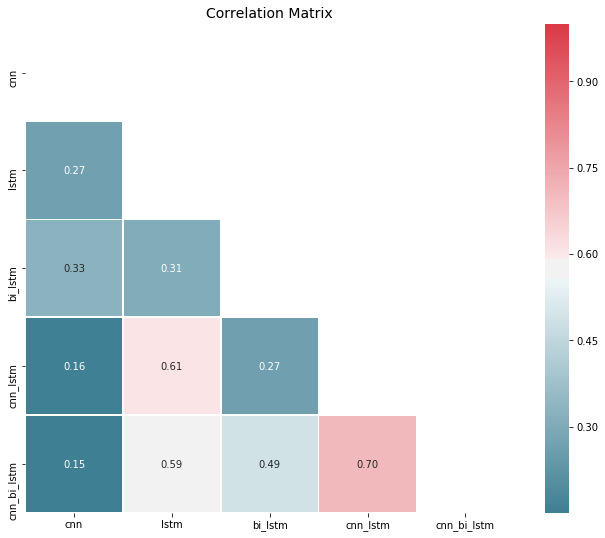

In [48]:
# corrmat(pred_df.corr(), inflate=False,show=False)
# plt.savefig('results/corr_matrix_base.png', bbox_inches='tight')
corrmat(pred_df.corr(), inflate=False)

## average

In [49]:
avg_pred_prob = pred_prob_base.mean(axis=2)

In [50]:
avg_pred_class = np.argmax(avg_pred_prob,axis=1)
avg_pred_class=avg_pred_class.astype(int)

In [51]:
acc = accuracy_score(testY,avg_pred_class)
acc

0.25

In [52]:
acc_results['average'] = acc

In [53]:
acc_results

{'average': 0.25,
 'base_model_counts': {'correct_predicted_by_all': 4,
  'correct_predicted_by_some': [26, 24, 13, 4],
  'incorrect_predicted_by_all': 29},
 'bi_lstm': 0.32,
 'cnn': 0.28,
 'cnn_bi_lstm': 0.29,
 'cnn_lstm': 0.22,
 'lstm': 0.38}

In [54]:
pred_df['average']=avg_pred_class

## Majority

In [55]:
majority_pred_class = [int(np.argmax(np.bincount(x))) for x in pred_class_base]

In [56]:
acc = accuracy_score(testY,majority_pred_class)
acc

0.3

In [57]:
acc_results['majority'] = acc

In [58]:
acc_results

{'average': 0.25,
 'base_model_counts': {'correct_predicted_by_all': 4,
  'correct_predicted_by_some': [26, 24, 13, 4],
  'incorrect_predicted_by_all': 29},
 'bi_lstm': 0.32,
 'cnn': 0.28,
 'cnn_bi_lstm': 0.29,
 'cnn_lstm': 0.22,
 'lstm': 0.38,
 'majority': 0.3}

In [59]:
pred_df['majority']=majority_pred_class

## Blend ensemble

In [60]:
seed=42

In [61]:
baseX, devX, baseY, devY = train_test_split(trainX, train_labels, test_size=0.10, random_state=seed)

In [62]:
baseY = np.array(baseY)
baseY = to_categorical(baseY,num_classes=number_of_classes)

In [63]:
len(baseX),len(baseY),len(devX),len(devY)

(450, 450, 50, 50)

In [64]:
metaX = np.zeros((len(devY),5),dtype=np.int32)

In [65]:
_,metaX[:,0],_ = get_pred_of_model(init_cnn(),cnn_parameter['epoch'],cnn_parameter['batch'],baseX,baseY,devX,devY)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 24, 300)           802200    
_________________________________________________________________
dropout_8 (Dropout)          (None, 24, 300)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 19, 100)           180100    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 200)               20200     
_________________________________________________________________
dropout_9 (Dropout)          (None, 200)               0         
_________________________________________________________________
activation_3 (Activation)    (None, 200)               0         
__________

In [66]:
_,metaX[:,1],_ = get_pred_of_model(init_lstm(),lstm_parameter['epoch'],lstm_parameter['batch'],baseX,baseY,devX,devY)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 24, 300)           802200    
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 645       
Total params: 1,022,493
Trainable params: 220,293
Non-trainable params: 802,200
_________________________________________________________________
None
Epoch 1/20
 - 4s - loss: 0.4975 - acc: 0.8000
Epoch 2/20
 - 2s - loss: 0.4916 - acc: 0.8000
Epoch 3/20
 - 2s - loss: 0.4900 - acc: 0.7996
Epoch 4/20
 - 2s - loss: 0.4880 - acc: 0.8000
Epoch 5/20
 - 2s - loss: 0.4893 - acc: 0.7996
Epoch 6/20
 - 2s - loss: 0.4887 - acc: 0.7964
Epoch 7/20
 - 1s - loss: 0.4902 - acc: 0.7996
Epoch 8/20
 - 1s - loss: 0.4860 - acc: 0.8000
Epoch 9/20
 - 1s - 

In [67]:
_,metaX[:,2],_ = get_pred_of_model(init_bi_lstm(),bi_lstm_parameter['epoch'],bi_lstm_parameter['batch'],baseX,baseY,devX,devY)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 24, 300)           802200    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 512)               1140736   
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 2565      
Total params: 1,945,501
Trainable params: 1,143,301
Non-trainable params: 802,200
_________________________________________________________________
None
Epoch 1/5
 - 14s - loss: 0.4989 - acc: 0.8000
Epoch 2/5
 - 11s - loss: 0.4885 - acc: 0.8000
Epoch 3/5
 - 12s - loss: 0.4827 - acc: 0.8004
Epoch 4/5
 - 6s - loss: 0.4774 - acc: 0.8000
Epoch 5/5
 - 5s - loss: 0.4703 - acc: 0.8004
0.24


In [68]:
_,metaX[:,3],_ = get_pred_of_model(init_cnn_lstm(),cnn_lstm_parameter['epoch'],cnn_lstm_parameter['batch'],baseX,baseY,devX,devY)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 24, 300)           802200    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 24, 100)           30100     
_________________________________________________________________
dropout_11 (Dropout)         (None, 24, 100)           0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 12, 100)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 325       
Total para

In [69]:
_,metaX[:,4],_ = get_pred_of_model(init_cnn_bi_lstm(),cnn_bi_lstm_parameter['epoch'],cnn_bi_lstm_parameter['batch'],baseX,baseY,devX,devY)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 24, 300)           802200    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 24, 100)           30100     
_________________________________________________________________
dropout_13 (Dropout)         (None, 24, 100)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 12, 100)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 645       
Total para

In [70]:
len(devY),len(metaX)

(50, 50)

Logistic Regressing meta model

In [71]:
meta_model=LogisticRegression()

In [72]:
meta_model.fit(metaX,devY)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [73]:
blend_pred_class = meta_model.predict(pred_class_base)

In [74]:
acc = accuracy_score(testY,blend_pred_class)
acc

0.27

In [75]:
acc_results['blend'] = acc

In [76]:
acc_results

{'average': 0.25,
 'base_model_counts': {'correct_predicted_by_all': 4,
  'correct_predicted_by_some': [26, 24, 13, 4],
  'incorrect_predicted_by_all': 29},
 'bi_lstm': 0.32,
 'blend': 0.27,
 'cnn': 0.28,
 'cnn_bi_lstm': 0.29,
 'cnn_lstm': 0.22,
 'lstm': 0.38,
 'majority': 0.3}

In [77]:
pred_df['blend']=blend_pred_class

XGboost meta model

In [78]:
meta_model_xg = XGBClassifier()

In [79]:
# param_grid={
#     'max_depth': [3,4,5,6,7,8,9],
#     'subsample': [0.4,0.5,0.6,0.7,0.8,0.9,1.0],
#     'colsample_bytree': [0.5,0.6,0.7,0.8],
#     'n_estimators': [1000,2000,3000],
#     'reg_alpha': [0.01, 0.02, 0.03, 0.04]
# }

param_grid={
    'max_depth': [3,4],
    'subsample': [0.6,0.7],
    'colsample_bytree': [0.6,0.7],
    'n_estimators': [1000,2000],
    'reg_alpha': [0.01, 0.02]
}


In [80]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

In [81]:
grid_search = GridSearchCV(meta_model_xg, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold,verbose=1)

In [82]:
grid_result = grid_search.fit(metaX,devY)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x7ff8c9bedf60, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/hitkul/anaconda3/envs/ps3/lib/python3.6/si...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/hitkul.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7ff8c9bedf60, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/hitkul/anaconda3/envs/ps3/lib/python3.6/si...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/hitkul.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'grid_result = grid_search.fit(metaX,devY)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 15, 10, 1, 20, 732982, tzinfo=tzutc()), 'msg_id': 'CC52B5D587994B56836551638953FF09', 'msg_type': 'execute_request', 'session': '5F19D8171FF34AA29CD872FE94E92DCD', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'CC52B5D587994B56836551638953FF09', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'5F19D8171FF34AA29CD872FE94E92DCD']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'grid_result = grid_search.fit(metaX,devY)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 15, 10, 1, 20, 732982, tzinfo=tzutc()), 'msg_id': 'CC52B5D587994B56836551638953FF09', 'msg_type': 'execute_request', 'session': '5F19D8171FF34AA29CD872FE94E92DCD', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'CC52B5D587994B56836551638953FF09', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'5F19D8171FF34AA29CD872FE94E92DCD'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'grid_result = grid_search.fit(metaX,devY)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 15, 10, 1, 20, 732982, tzinfo=tzutc()), 'msg_id': 'CC52B5D587994B56836551638953FF09', 'msg_type': 'execute_request', 'session': '5F19D8171FF34AA29CD872FE94E92DCD', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'CC52B5D587994B56836551638953FF09', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='grid_result = grid_search.fit(metaX,devY)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'grid_result = grid_search.fit(metaX,devY)'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('grid_result = grid_search.fit(metaX,devY)',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('grid_result = grid_search.fit(metaX,devY)',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='grid_result = grid_search.fit(metaX,devY)', store_history=True, silent=False, shell_futures=True)
   2693                 self.displayhook.exec_result = result
   2694 
   2695                 # Execute the user code
   2696                 interactivity = "none" if silent else self.ast_node_interactivity
   2697                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2698                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2699                 
   2700                 self.last_execution_succeeded = not has_raised
   2701 
   2702                 # Reset this so later displayed values do not modify the

...........................................................................
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>], cell_name='<ipython-input-82-c1e5ff0f2cdd>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7ff730124b00, executi..._before_exec=None error_in_exec=None result=None>)
   2797 
   2798         try:
   2799             for i, node in enumerate(to_run_exec):
   2800                 mod = ast.Module([node])
   2801                 code = compiler(mod, cell_name, "exec")
-> 2802                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7ff72b7c3540, file "<ipython-input-82-c1e5ff0f2cdd>", line 1>
        result = <ExecutionResult object at 7ff730124b00, executi..._before_exec=None error_in_exec=None result=None>
   2803                     return True
   2804 
   2805             for i, node in enumerate(to_run_interactive):
   2806                 mod = ast.Interactive([node])

...........................................................................
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7ff72b7c3540, file "<ipython-input-82-c1e5ff0f2cdd>", line 1>, result=<ExecutionResult object at 7ff730124b00, executi..._before_exec=None error_in_exec=None result=None>)
   2857         outflag = True  # happens in more places, so it's easier as default
   2858         try:
   2859             try:
   2860                 self.hooks.pre_run_code_hook()
   2861                 #rprint('Running code', repr(code_obj)) # dbg
-> 2862                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7ff72b7c3540, file "<ipython-input-82-c1e5ff0f2cdd>", line 1>
        self.user_global_ns = {'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "# import matplotlib\n# matplotlib.use('Agg')\nimpo...\nfrom sklearn.model_selection import GridSearchCV", 'def load_data_from_file(filename):\n    with open...()[1:]) for x in lines]\n    return label,sentence', "train_labels,train_sentences = load_data_from_fi...oad_data_from_file('dataset/sst1/stsa.fine.test')", 'train_sentences = train_sentences+dev_sentence\ntrain_labels = train_labels+dev_label', 'len(train_labels),len(train_sentences),len(test_labels),len(test_sentences)', 'train_labels = train_labels[:500]\ntrain_sentence...abels[:100]\ntest_sentences = test_sentences[:100]', 'number_of_classes = len(set(train_labels))\nnumber_of_classes', 'len(train_labels),len(train_sentences),len(test_labels),len(test_sentences)', "def remove_punctuation(s):\n    list_punctuation ...tuation:\n        s = s.replace(i,'')\n    return s", "def clean_sentence(sentence):\n    #removes links...]\n    tokens = ' '.join(tokens)\n    return tokens", 'print("cleaning data")\ntrainX = [clean_sentence(...trainY = np.array(train_labels)\ntestY=test_labels', 'max_len = 24', 'def create_tokenizer(lines):\n    tokenizer = Tok...okenizer.fit_on_texts(lines)\n    return tokenizer', "def encode_text(tokenizer, lines, length):\n    e... maxlen=length, padding='post')\n    return padded", 'def load_godin_word_embedding(path):\n    print("....Word2Vec.load_word2vec_format(path, binary=True)', 'def load_google_word2vec(file_name):\n    print("...tors.load_word2vec_format(file_name, binary=True)', 'def get_word_embedding_matrix(model,dim):\n    #d...x[i]=embedding_vector\n    return embedding_matrix', 'tokenizer = create_tokenizer(trainX)\nvocab_size ...categorical(trainY,num_classes=number_of_classes)', '# godin_model = load_godin_word_embedding("../wo...d_embeddings/GoogleNews-vectors-negative300.bin\')', ...], 'K': <module 'keras.backend' from '/home/hitkul/anaco...thon3.6/site-packages/keras/backend/__init__.py'>, 'KeyedVectors': <class 'gensim.models.keyedvectors.EuclideanKeyedVectors'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {5: (9645, 9645, 2210, 2210), 7: 5, 8: (500, 500, 100, 100), 34: {'average': 0.25, 'base_model_counts': {'correct_predicted_by_all': 4, 'correct_predicted_by_some': [26, 24, 13, 4], 'incorrect_predicted_by_all': 29}, 'bi_lstm': 0.32, 'blend': 0.27, 'cnn': 0.28, 'cnn_bi_lstm': 0.29, 'cnn_lstm': 0.22, 'lstm': 0.38, 'majority': 0.3}, 35: array([[1, 1, 1, 2, 2],
       [3, 3, 3, 4, 3],
..., 3, 2, 2],
       [3, 1, 3, 4, 3]], dtype=int32), 36: array([[[0.18933415, 0.23297822, 0.17012943, 0.1....26987383, 0.17061943, 0.49888965, 0.12068157]]]), 41: (29, 4, [26, 24, 13, 4]), 45: {'average': 0.25, 'base_model_counts': {'correct_predicted_by_all': 4, 'correct_predicted_by_some': [26, 24, 13, 4], 'incorrect_predicted_by_all': 29}, 'bi_lstm': 0.32, 'blend': 0.27, 'cnn': 0.28, 'cnn_bi_lstm': 0.29, 'cnn_lstm': 0.22, 'lstm': 0.38, 'majority': 0.3}, 47:    cnn  lstm  bi_lstm  cnn_lstm  cnn_bi_lstm
0  ...   2
4    3     1        1         2            0, 48: <matplotlib.axes._subplots.AxesSubplot object>, ...}, 'StratifiedKFold': <class 'sklearn.model_selection._split.StratifiedKFold'>, 'Tokenizer': <class 'keras.preprocessing.text.Tokenizer'>, 'XGBClassifier': <class 'xgboost.sklearn.XGBClassifier'>, '_': array([[0.19140796, 0.26737565, 0.27935123, 0.21...3, 0.21926825, 0.01320084]],
      dtype=float32), ...}
        self.user_ns = {'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "# import matplotlib\n# matplotlib.use('Agg')\nimpo...\nfrom sklearn.model_selection import GridSearchCV", 'def load_data_from_file(filename):\n    with open...()[1:]) for x in lines]\n    return label,sentence', "train_labels,train_sentences = load_data_from_fi...oad_data_from_file('dataset/sst1/stsa.fine.test')", 'train_sentences = train_sentences+dev_sentence\ntrain_labels = train_labels+dev_label', 'len(train_labels),len(train_sentences),len(test_labels),len(test_sentences)', 'train_labels = train_labels[:500]\ntrain_sentence...abels[:100]\ntest_sentences = test_sentences[:100]', 'number_of_classes = len(set(train_labels))\nnumber_of_classes', 'len(train_labels),len(train_sentences),len(test_labels),len(test_sentences)', "def remove_punctuation(s):\n    list_punctuation ...tuation:\n        s = s.replace(i,'')\n    return s", "def clean_sentence(sentence):\n    #removes links...]\n    tokens = ' '.join(tokens)\n    return tokens", 'print("cleaning data")\ntrainX = [clean_sentence(...trainY = np.array(train_labels)\ntestY=test_labels', 'max_len = 24', 'def create_tokenizer(lines):\n    tokenizer = Tok...okenizer.fit_on_texts(lines)\n    return tokenizer', "def encode_text(tokenizer, lines, length):\n    e... maxlen=length, padding='post')\n    return padded", 'def load_godin_word_embedding(path):\n    print("....Word2Vec.load_word2vec_format(path, binary=True)', 'def load_google_word2vec(file_name):\n    print("...tors.load_word2vec_format(file_name, binary=True)', 'def get_word_embedding_matrix(model,dim):\n    #d...x[i]=embedding_vector\n    return embedding_matrix', 'tokenizer = create_tokenizer(trainX)\nvocab_size ...categorical(trainY,num_classes=number_of_classes)', '# godin_model = load_godin_word_embedding("../wo...d_embeddings/GoogleNews-vectors-negative300.bin\')', ...], 'K': <module 'keras.backend' from '/home/hitkul/anaco...thon3.6/site-packages/keras/backend/__init__.py'>, 'KeyedVectors': <class 'gensim.models.keyedvectors.EuclideanKeyedVectors'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {5: (9645, 9645, 2210, 2210), 7: 5, 8: (500, 500, 100, 100), 34: {'average': 0.25, 'base_model_counts': {'correct_predicted_by_all': 4, 'correct_predicted_by_some': [26, 24, 13, 4], 'incorrect_predicted_by_all': 29}, 'bi_lstm': 0.32, 'blend': 0.27, 'cnn': 0.28, 'cnn_bi_lstm': 0.29, 'cnn_lstm': 0.22, 'lstm': 0.38, 'majority': 0.3}, 35: array([[1, 1, 1, 2, 2],
       [3, 3, 3, 4, 3],
..., 3, 2, 2],
       [3, 1, 3, 4, 3]], dtype=int32), 36: array([[[0.18933415, 0.23297822, 0.17012943, 0.1....26987383, 0.17061943, 0.49888965, 0.12068157]]]), 41: (29, 4, [26, 24, 13, 4]), 45: {'average': 0.25, 'base_model_counts': {'correct_predicted_by_all': 4, 'correct_predicted_by_some': [26, 24, 13, 4], 'incorrect_predicted_by_all': 29}, 'bi_lstm': 0.32, 'blend': 0.27, 'cnn': 0.28, 'cnn_bi_lstm': 0.29, 'cnn_lstm': 0.22, 'lstm': 0.38, 'majority': 0.3}, 47:    cnn  lstm  bi_lstm  cnn_lstm  cnn_bi_lstm
0  ...   2
4    3     1        1         2            0, 48: <matplotlib.axes._subplots.AxesSubplot object>, ...}, 'StratifiedKFold': <class 'sklearn.model_selection._split.StratifiedKFold'>, 'Tokenizer': <class 'keras.preprocessing.text.Tokenizer'>, 'XGBClassifier': <class 'xgboost.sklearn.XGBClassifier'>, '_': array([[0.19140796, 0.26737565, 0.27935123, 0.21...3, 0.21926825, 0.01320084]],
      dtype=float32), ...}
   2863             finally:
   2864                 # Reset our crash handler in place
   2865                 sys.excepthook = old_excepthook
   2866         except SystemExit as e:

...........................................................................
/home/hitkul/Desktop/ps3_iiit/ensembl_work/ensemble_experiments/sst1/<ipython-input-82-c1e5ff0f2cdd> in <module>()
----> 1 grid_result = grid_search.fit(metaX,devY)

...........................................................................
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=StratifiedKFold(n_splits=10, ran...'warn',
       scoring='neg_log_loss', verbose=1), X=array([[3, 1, 3, 1, 2],
       [3, 1, 1, 1, 1],
..., 3, 3, 3],
       [3, 1, 3, 2, 1]], dtype=int32), y=[3, 0, 4, 0, 1, 0, 3, 1, 4, 4, 4, 4, 2, 1, 3, 2, 3, 4, 0, 4, ...], groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of StratifiedKFold(n_splits=10, random_state=42, shuffle=True)>
        X = array([[3, 1, 3, 1, 2],
       [3, 1, 1, 1, 1],
..., 3, 3, 3],
       [3, 1, 3, 2, 1]], dtype=int32)
        y = [3, 0, 4, 0, 1, 0, 3, 1, 4, 4, 4, 4, 2, 1, 3, 2, 3, 4, 0, 4, ...]
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sun Apr 15 15:31:23 2018
PID: 597           Python 3.6.3: /home/hitkul/anaconda3/envs/ps3/bin/python
...........................................................................
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (XGBClassifier(base_score=0.5, booster='gbtree', ...=1, seed=None,
       silent=True, subsample=0.6), array([[3, 1, 3, 1, 2],
       [3, 1, 1, 1, 1],
..., 3, 3, 3],
       [3, 1, 3, 2, 1]], dtype=int32), [3, 0, 4, 0, 1, 0, 3, 1, 4, 4, 4, 4, 2, 1, 3, 2, 3, 4, 0, 4, ...], {'score': make_scorer(log_loss, greater_is_better=False, needs_proba=True)}, array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 1...,
       39, 40, 41, 42, 44, 45, 46, 47, 48, 49]), array([ 0, 29, 30, 34, 38, 43]), 1, {'colsample_bytree': 0.6, 'max_depth': 3, 'n_estimators': 1000, 'reg_alpha': 0.01, 'subsample': 0.6}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (XGBClassifier(base_score=0.5, booster='gbtree', ...=1, seed=None,
       silent=True, subsample=0.6), array([[3, 1, 3, 1, 2],
       [3, 1, 1, 1, 1],
..., 3, 3, 3],
       [3, 1, 3, 2, 1]], dtype=int32), [3, 0, 4, 0, 1, 0, 3, 1, 4, 4, 4, 4, 2, 1, 3, 2, 3, 4, 0, 4, ...], {'score': make_scorer(log_loss, greater_is_better=False, needs_proba=True)}, array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 1...,
       39, 40, 41, 42, 44, 45, 46, 47, 48, 49]), array([ 0, 29, 30, 34, 38, 43]), 1, {'colsample_bytree': 0.6, 'max_depth': 3, 'n_estimators': 1000, 'reg_alpha': 0.01, 'subsample': 0.6})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=XGBClassifier(base_score=0.5, booster='gbtree', ...=1, seed=None,
       silent=True, subsample=0.6), X=array([[3, 1, 3, 1, 2],
       [3, 1, 1, 1, 1],
..., 3, 3, 3],
       [3, 1, 3, 2, 1]], dtype=int32), y=[3, 0, 4, 0, 1, 0, 3, 1, 4, 4, 4, 4, 2, 1, 3, 2, 3, 4, 0, 4, ...], scorer={'score': make_scorer(log_loss, greater_is_better=False, needs_proba=True)}, train=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 1...,
       39, 40, 41, 42, 44, 45, 46, 47, 48, 49]), test=array([ 0, 29, 30, 34, 38, 43]), verbose=1, parameters={'colsample_bytree': 0.6, 'max_depth': 3, 'n_estimators': 1000, 'reg_alpha': 0.01, 'subsample': 0.6}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    483                              " make sure that it has been spelled correctly.)")
    484 
    485     else:
    486         fit_time = time.time() - start_time
    487         # _score will return dict if is_multimetric is True
--> 488         test_scores = _score(estimator, X_test, y_test, scorer, is_multimetric)
        test_scores = {}
        estimator = XGBClassifier(base_score=0.5, booster='gbtree', ...=1, seed=None,
       silent=True, subsample=0.6)
        X_test = array([[3, 1, 3, 1, 2],
       [3, 1, 3, 3, 3],
..., 3, 2, 1],
       [3, 4, 3, 4, 4]], dtype=int32)
        y_test = [3, 3, 4, 1, 1, 4]
        scorer = {'score': make_scorer(log_loss, greater_is_better=False, needs_proba=True)}
        is_multimetric = True
    489         score_time = time.time() - start_time - fit_time
    490         if return_train_score:
    491             train_scores = _score(estimator, X_train, y_train, scorer,
    492                                   is_multimetric)

...........................................................................
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _score(estimator=XGBClassifier(base_score=0.5, booster='gbtree', ...=1, seed=None,
       silent=True, subsample=0.6), X_test=array([[3, 1, 3, 1, 2],
       [3, 1, 3, 3, 3],
..., 3, 2, 1],
       [3, 4, 3, 4, 4]], dtype=int32), y_test=[3, 3, 4, 1, 1, 4], scorer={'score': make_scorer(log_loss, greater_is_better=False, needs_proba=True)}, is_multimetric=True)
    518 
    519     Will return a single float if is_multimetric is False and a dict of floats,
    520     if is_multimetric is True
    521     """
    522     if is_multimetric:
--> 523         return _multimetric_score(estimator, X_test, y_test, scorer)
        estimator = XGBClassifier(base_score=0.5, booster='gbtree', ...=1, seed=None,
       silent=True, subsample=0.6)
        X_test = array([[3, 1, 3, 1, 2],
       [3, 1, 3, 3, 3],
..., 3, 2, 1],
       [3, 4, 3, 4, 4]], dtype=int32)
        y_test = [3, 3, 4, 1, 1, 4]
        scorer = {'score': make_scorer(log_loss, greater_is_better=False, needs_proba=True)}
    524     else:
    525         if y_test is None:
    526             score = scorer(estimator, X_test)
    527         else:

...........................................................................
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _multimetric_score(estimator=XGBClassifier(base_score=0.5, booster='gbtree', ...=1, seed=None,
       silent=True, subsample=0.6), X_test=array([[3, 1, 3, 1, 2],
       [3, 1, 3, 3, 3],
..., 3, 2, 1],
       [3, 4, 3, 4, 4]], dtype=int32), y_test=[3, 3, 4, 1, 1, 4], scorers={'score': make_scorer(log_loss, greater_is_better=False, needs_proba=True)})
    548 
    549     for name, scorer in scorers.items():
    550         if y_test is None:
    551             score = scorer(estimator, X_test)
    552         else:
--> 553             score = scorer(estimator, X_test, y_test)
        score = undefined
        scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
        estimator = XGBClassifier(base_score=0.5, booster='gbtree', ...=1, seed=None,
       silent=True, subsample=0.6)
        X_test = array([[3, 1, 3, 1, 2],
       [3, 1, 3, 3, 3],
..., 3, 2, 1],
       [3, 4, 3, 4, 4]], dtype=int32)
        y_test = [3, 3, 4, 1, 1, 4]
    554 
    555         if hasattr(score, 'item'):
    556             try:
    557                 # e.g. unwrap memmapped scalars

...........................................................................
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/metrics/scorer.py in __call__(self=make_scorer(log_loss, greater_is_better=False, needs_proba=True), clf=XGBClassifier(base_score=0.5, booster='gbtree', ...=1, seed=None,
       silent=True, subsample=0.6), X=array([[3, 1, 3, 1, 2],
       [3, 1, 3, 3, 3],
..., 3, 2, 1],
       [3, 4, 3, 4, 4]], dtype=int32), y=[3, 3, 4, 1, 1, 4], sample_weight=None)
    139         if sample_weight is not None:
    140             return self._sign * self._score_func(y, y_pred,
    141                                                  sample_weight=sample_weight,
    142                                                  **self._kwargs)
    143         else:
--> 144             return self._sign * self._score_func(y, y_pred, **self._kwargs)
        self._sign = -1
        self._score_func = <function log_loss>
        y = [3, 3, 4, 1, 1, 4]
        y_pred = array([[4.6107150e-03, 6.6105820e-02, 9.2523319e...7611e-01,
        4.9448857e-01]], dtype=float32)
        self._kwargs = {}
    145 
    146     def _factory_args(self):
    147         return ", needs_proba=True"
    148 

...........................................................................
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/metrics/classification.py in log_loss(y_true=[3, 3, 4, 1, 1, 4], y_pred=array([[4.6107150e-03, 6.6105820e-02, 9.2523319e...7611e-01,
        4.9448857e-01]], dtype=float32), eps=1e-15, normalize=True, sample_weight=None, labels=None)
   1681                              "classes {0}, {1}. Please provide the true "
   1682                              "labels explicitly through the labels argument. "
   1683                              "Classes found in "
   1684                              "y_true: {2}".format(transformed_labels.shape[1],
   1685                                                   y_pred.shape[1],
-> 1686                                                   lb.classes_))
        lb.classes_ = array([1, 3, 4])
   1687         else:
   1688             raise ValueError('The number of classes in labels is different '
   1689                              'from that in y_pred. Classes found in '
   1690                              'labels: {0}'.format(lb.classes_))

ValueError: y_true and y_pred contain different number of classes 3, 5. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [1 3 4]
___________________________________________________________________________

In [ ]:
best_est_blen_xg = grid_result.best_estimator_

In [167]:
blend_pred_class_xg = best_est_blen_xg.predict(pred_class_base)

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [171]:
acc = accuracy_score(testY,blend_pred_class_xg)
acc

0.32

In [172]:
acc_results['blend_xg'] = acc

In [173]:
acc_results

{'average': 0.36,
 'base_model_counts': {'correct_predicted_by_all': 2,
  'correct_predicted_by_some': [25, 21, 15, 8],
  'incorrect_predicted_by_all': 29},
 'bi_lstm': 0.33,
 'blend': 0.34,
 'blend_xg': 0.32,
 'cnn': 0.26,
 'cnn_bi_lstm': 0.34,
 'cnn_lstm': 0.29,
 'lstm': 0.32,
 'majority': 0.36}

In [174]:
pred_df['blend_xg']=blend_pred_class_xg

## Stacked ensemble

In [175]:
np.random.seed(seed)

In [176]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

In [177]:
stacked_metaX=np.array([[0, 0, 0, 0,0]],dtype=np.int64)

In [178]:
stacked_metaY = []

In [179]:
count=1

In [180]:
trainX=[clean_sentence(x) for x in train_sentences]

In [181]:
trainY=train_labels

In [182]:
trainY=np.array(trainY)
trainX=np.array(trainX)

In [183]:
for train,test in kfold.split(trainX,trainY):
    print("----------------------itr = {}--------------".format(count))
    stacked_trainX = list(trainX[train])
    stacked_trainY = list(trainY[train])
    stacked_testX = list(trainX[test])
    stacked_testY = list(trainY[test])
    
    tokenizer = create_tokenizer(stacked_trainX)
    vocab_size = len(tokenizer.word_index) + 1
    stacked_trainX = encode_text(tokenizer, stacked_trainX, max_len)
    stacked_testX = encode_text(tokenizer, stacked_testX, max_len)
    stacked_trainY = to_categorical(stacked_trainY,num_classes=number_of_classes)
    
    embedding_matrix_word2vec = get_word_embedding_matrix(word2vec_model,300)
    
    for i in stacked_testY:
        stacked_metaY.append(i)
        
    temp = np.zeros((len(stacked_testY),5),dtype=np.int64)
    
    _,temp[:,0],_ = get_pred_of_model(init_cnn(),cnn_parameter['epoch'],cnn_parameter['batch'],stacked_trainX,stacked_trainY,stacked_testX,stacked_testY)
    _,temp[:,1],_ = get_pred_of_model(init_lstm(),lstm_parameter['epoch'],lstm_parameter['batch'],stacked_trainX,stacked_trainY,stacked_testX,stacked_testY)
    _,temp[:,2],_ = get_pred_of_model(init_bi_lstm(),bi_lstm_parameter['epoch'],bi_lstm_parameter['batch'],stacked_trainX,stacked_trainY,stacked_testX,stacked_testY)
    _,temp[:,3],_ = get_pred_of_model(init_cnn_lstm(),cnn_lstm_parameter['epoch'],cnn_lstm_parameter['batch'],stacked_trainX,stacked_trainY,stacked_testX,stacked_testY)
    _,temp[:,4],_ = get_pred_of_model(init_cnn_bi_lstm(),cnn_bi_lstm_parameter['epoch'],cnn_bi_lstm_parameter['batch'],stacked_trainX,stacked_trainY,stacked_testX,stacked_testY)
    
    stacked_metaX = np.concatenate((stacked_metaX, temp), axis=0)
    count+=1

----------------------itr = 1--------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 24, 300)           759000    
_________________________________________________________________
dropout_29 (Dropout)         (None, 24, 300)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 19, 100)           180100    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 100)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 200)               20200     
_________________________________________________________________
dropout_30 (Dropout)         (None, 200)               0         
_________________________________________________________________
activation_9 (Activation)    (No

Epoch 1/10
 - 4s - loss: 0.5158 - acc: 0.7960
Epoch 2/10
 - 1s - loss: 0.5085 - acc: 0.7973
Epoch 3/10
 - 1s - loss: 0.5006 - acc: 0.7982
Epoch 4/10
 - 1s - loss: 0.4951 - acc: 0.7969
Epoch 5/10
 - 1s - loss: 0.4905 - acc: 0.8000
Epoch 6/10
 - 1s - loss: 0.4922 - acc: 0.7973
Epoch 7/10
 - 1s - loss: 0.4827 - acc: 0.7996
Epoch 8/10
 - 1s - loss: 0.4809 - acc: 0.8000
Epoch 9/10
 - 1s - loss: 0.4774 - acc: 0.8018
Epoch 10/10
 - 1s - loss: 0.4814 - acc: 0.7973
0.3269230769230769
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 24, 300)           748200    
_________________________________________________________________
lstm_21 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dense_33 (Dense)             (None, 5)                 645       
Total params: 968,493
Trainable params: 220,293
Non-traina

 - 1s - loss: 0.5047 - acc: 0.7960
Epoch 3/10
 - 1s - loss: 0.4986 - acc: 0.7973
Epoch 4/10
 - 1s - loss: 0.4873 - acc: 0.7982
Epoch 5/10
 - 1s - loss: 0.4970 - acc: 0.7982
Epoch 6/10
 - 1s - loss: 0.4875 - acc: 0.7991
Epoch 7/10
 - 1s - loss: 0.4823 - acc: 0.7996
Epoch 8/10
 - 1s - loss: 0.4857 - acc: 0.8004
Epoch 9/10
 - 1s - loss: 0.4832 - acc: 0.8004
Epoch 10/10
 - 1s - loss: 0.4803 - acc: 0.8004
0.34615384615384615
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 24, 300)           742500    
_________________________________________________________________
lstm_25 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dense_39 (Dense)             (None, 5)                 645       
Total params: 962,793
Trainable params: 220,293
Non-trainable params: 742,500
____________________________________

Epoch 4/10
 - 1s - loss: 0.4972 - acc: 0.8004
Epoch 5/10
 - 1s - loss: 0.4902 - acc: 0.7947
Epoch 6/10
 - 1s - loss: 0.4939 - acc: 0.7978
Epoch 7/10
 - 1s - loss: 0.4923 - acc: 0.7969
Epoch 8/10
 - 1s - loss: 0.4882 - acc: 0.7991
Epoch 9/10
 - 1s - loss: 0.4782 - acc: 0.8009
Epoch 10/10
 - 1s - loss: 0.4824 - acc: 0.7964
0.32
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_37 (Embedding)     (None, 24, 300)           740100    
_________________________________________________________________
lstm_29 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dense_45 (Dense)             (None, 5)                 645       
Total params: 960,393
Trainable params: 220,293
Non-trainable params: 740,100
_________________________________________________________________
None
Epoch 1/20
 - 5s - loss: 0.4964 - acc: 0.8000
Epoch 2/20
 - 1

Epoch 7/10
 - 1s - loss: 0.4892 - acc: 0.7991
Epoch 8/10
 - 1s - loss: 0.4829 - acc: 0.7996
Epoch 9/10
 - 1s - loss: 0.4817 - acc: 0.8004
Epoch 10/10
 - 1s - loss: 0.4748 - acc: 0.8013
0.30612244897959184
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_42 (Embedding)     (None, 24, 300)           735300    
_________________________________________________________________
lstm_33 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dense_51 (Dense)             (None, 5)                 645       
Total params: 955,593
Trainable params: 220,293
Non-trainable params: 735,300
_________________________________________________________________
None
Epoch 1/20
 - 5s - loss: 0.4933 - acc: 0.8000
Epoch 2/20
 - 1s - loss: 0.5019 - acc: 0.7929
Epoch 3/20
 - 1s - loss: 0.4924 - acc: 0.8000
Epoch 4/20
 - 1s - loss: 0.4914 - acc: 0.8000


 - 1s - loss: 0.4915 - acc: 0.7991
Epoch 9/10
 - 1s - loss: 0.4789 - acc: 0.8009
Epoch 10/10
 - 1s - loss: 0.4785 - acc: 0.8004
0.3469387755102041
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_47 (Embedding)     (None, 24, 300)           737100    
_________________________________________________________________
lstm_37 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dense_57 (Dense)             (None, 5)                 645       
Total params: 957,393
Trainable params: 220,293
Non-trainable params: 737,100
_________________________________________________________________
None
Epoch 1/20
 - 8s - loss: 0.4978 - acc: 0.8000
Epoch 2/20
 - 1s - loss: 0.4900 - acc: 0.7996
Epoch 3/20
 - 1s - loss: 0.4912 - acc: 0.8000
Epoch 4/20
 - 1s - loss: 0.4828 - acc: 0.8000
Epoch 5/20
 - 1s - loss: 0.4844 - acc: 0.8000
Epoch 6/20
 

Epoch 10/10
 - 1s - loss: 0.4829 - acc: 0.8018
0.2653061224489796
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_52 (Embedding)     (None, 24, 300)           751500    
_________________________________________________________________
lstm_41 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dense_63 (Dense)             (None, 5)                 645       
Total params: 971,793
Trainable params: 220,293
Non-trainable params: 751,500
_________________________________________________________________
None
Epoch 1/20
 - 7s - loss: 0.4980 - acc: 0.8000
Epoch 2/20
 - 1s - loss: 0.4908 - acc: 0.8000
Epoch 3/20
 - 1s - loss: 0.4900 - acc: 0.8009
Epoch 4/20
 - 1s - loss: 0.4932 - acc: 0.8000
Epoch 5/20
 - 1s - loss: 0.4830 - acc: 0.7996
Epoch 6/20
 - 1s - loss: 0.4789 - acc: 0.7969
Epoch 7/20
 - 1s - loss: 0.4848 - acc: 0.7925
E

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_57 (Embedding)     (None, 24, 300)           742500    
_________________________________________________________________
lstm_45 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dense_69 (Dense)             (None, 5)                 645       
Total params: 962,793
Trainable params: 220,293
Non-trainable params: 742,500
_________________________________________________________________
None
Epoch 1/20
 - 7s - loss: 0.4985 - acc: 0.8000
Epoch 2/20
 - 1s - loss: 0.4898 - acc: 0.8004
Epoch 3/20
 - 1s - loss: 0.4920 - acc: 0.7996
Epoch 4/20
 - 1s - loss: 0.4889 - acc: 0.8000
Epoch 5/20
 - 1s - loss: 0.4891 - acc: 0.8000
Epoch 6/20
 - 1s - loss: 0.4847 - acc: 0.7973
Epoch 7/20
 - 1s - loss: 0.4837 - acc: 0.7996
Epoch 8/20
 - 1s - loss: 0.4772 - acc: 0.7973
Epoch 9/20
 - 1s - lo

Epoch 1/20
 - 8s - loss: 0.4979 - acc: 0.8000
Epoch 2/20
 - 1s - loss: 0.4893 - acc: 0.8004
Epoch 3/20
 - 1s - loss: 0.4918 - acc: 0.8000
Epoch 4/20
 - 1s - loss: 0.4899 - acc: 0.8009
Epoch 5/20
 - 1s - loss: 0.4897 - acc: 0.7996
Epoch 6/20
 - 1s - loss: 0.4868 - acc: 0.8000
Epoch 7/20
 - 1s - loss: 0.4887 - acc: 0.7996
Epoch 8/20
 - 1s - loss: 0.4887 - acc: 0.8004
Epoch 9/20
 - 1s - loss: 0.4837 - acc: 0.8018
Epoch 10/20
 - 1s - loss: 0.4829 - acc: 0.7965
Epoch 11/20
 - 1s - loss: 0.4872 - acc: 0.7960
Epoch 12/20
 - 1s - loss: 0.4830 - acc: 0.8000
Epoch 13/20
 - 1s - loss: 0.4781 - acc: 0.8022
Epoch 14/20
 - 1s - loss: 0.4739 - acc: 0.7991
Epoch 15/20
 - 1s - loss: 0.4714 - acc: 0.7996
Epoch 16/20
 - 1s - loss: 0.4809 - acc: 0.7925
Epoch 17/20
 - 1s - loss: 0.4805 - acc: 0.7973
Epoch 18/20
 - 1s - loss: 0.4770 - acc: 0.8013
Epoch 19/20
 - 1s - loss: 0.4731 - acc: 0.7960
Epoch 20/20
 - 1s - loss: 0.4639 - acc: 0.8000
0.24489795918367346
_________________________________________________

Epoch 3/20
 - 1s - loss: 0.4873 - acc: 0.7991
Epoch 4/20
 - 1s - loss: 0.4898 - acc: 0.7996
Epoch 5/20
 - 1s - loss: 0.4856 - acc: 0.8009
Epoch 6/20
 - 1s - loss: 0.4915 - acc: 0.8004
Epoch 7/20
 - 1s - loss: 0.4864 - acc: 0.8000
Epoch 8/20
 - 1s - loss: 0.4800 - acc: 0.8013
Epoch 9/20
 - 1s - loss: 0.4794 - acc: 0.7973
Epoch 10/20
 - 1s - loss: 0.4763 - acc: 0.7973
Epoch 11/20
 - 1s - loss: 0.4790 - acc: 0.8000
Epoch 12/20
 - 1s - loss: 0.4736 - acc: 0.7956
Epoch 13/20
 - 1s - loss: 0.4700 - acc: 0.7982
Epoch 14/20
 - 1s - loss: 0.4743 - acc: 0.7978
Epoch 15/20
 - 1s - loss: 0.4760 - acc: 0.7942
Epoch 16/20
 - 1s - loss: 0.4725 - acc: 0.7987
Epoch 17/20
 - 1s - loss: 0.4791 - acc: 0.7885
Epoch 18/20
 - 1s - loss: 0.4770 - acc: 0.7960
Epoch 19/20
 - 1s - loss: 0.4732 - acc: 0.8000
Epoch 20/20
 - 1s - loss: 0.4757 - acc: 0.7991
0.3125
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_68 (Embeddin

In [184]:
len(stacked_metaX),len(stacked_metaY)

(501, 500)

In [185]:
stacked_metaX = np.delete(stacked_metaX, (0), axis=0)

In [186]:
#temp line
# stacked_metaY=stacked_metaY[-500:]

In [187]:
len(stacked_metaX),len(stacked_metaY)

(500, 500)

In [188]:
stacked_meta_model=LogisticRegression()

In [189]:
stacked_meta_model.fit(stacked_metaX,stacked_metaY)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [190]:
stacked_pred_class = stacked_meta_model.predict(pred_class_base)

In [191]:
acc = accuracy_score(testY,stacked_pred_class)
acc

0.36

In [192]:
acc_results['stacked'] = acc

In [193]:
acc_results

{'average': 0.36,
 'base_model_counts': {'correct_predicted_by_all': 2,
  'correct_predicted_by_some': [25, 21, 15, 8],
  'incorrect_predicted_by_all': 29},
 'bi_lstm': 0.33,
 'blend': 0.34,
 'blend_xg': 0.32,
 'cnn': 0.26,
 'cnn_bi_lstm': 0.34,
 'cnn_lstm': 0.29,
 'lstm': 0.32,
 'majority': 0.36,
 'stacked': 0.36}

In [194]:
pred_df['stacked']=stacked_pred_class

xgboost meta model

In [197]:
# stacked_metaX
# stacked_metaY

In [198]:
best_params, history = tune_xgb_params(
    cv_folds=10,
    label=np.array(stacked_metaY),
    metric_sklearn='accuracy',
    metric_xgb='merror',
    n_jobs=4,
    objective='multi:softprob',
    random_state=seed,
    strategy='randomized',
    train=stacked_metaX,
    colsample_bytree_loc=0.5,
    colsample_bytree_scale=0.2,
    subsample_loc=0.5,
    subsample_scale=0.2
)

[0]	train-merror:0.613086+0.017723	test-merror:0.698007+0.0314241
[1]	train-merror:0.592019+0.0121506	test-merror:0.694171+0.0183332
[2]	train-merror:0.588033+0.00738515	test-merror:0.694218+0.0319842
[3]	train-merror:0.575017+0.0107114	test-merror:0.680137+0.0196248
[4]	train-merror:0.575023+0.014948	test-merror:0.678129+0.0171487
[5]	train-merror:0.572047+0.0158691	test-merror:0.680197+0.0209734
[6]	train-merror:0.562049+0.0171796	test-merror:0.688194+0.0245953
[7]	train-merror:0.553003+0.0145856	test-merror:0.680197+0.0209734
[8]	train-merror:0.557023+0.0149199	test-merror:0.686258+0.0253611
[9]	train-merror:0.552033+0.0137828	test-merror:0.682218+0.0221659
[10]	train-merror:0.554053+0.0198694	test-merror:0.688277+0.0323999
[11]	train-merror:0.546081+0.0184426	test-merror:0.686317+0.0338945
[12]	train-merror:0.548083+0.0195143	test-merror:0.690214+0.0249812
[13]	train-merror:0.550064+0.0167712	test-merror:0.688158+0.0197414
[14]	train-merror:0.550043+0.0131644	test-merror:0.684153+0

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399, score=0.38, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399, score=0.37735849056603776, total=   0.0s
[CV]  colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399, score=0.28846153846153844, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399, score=0.30612244897959184, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399, score=0.40384615384615385, total=   0.0s
[CV] colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399, score=0.30612244897959184, total=   0.0s
[CV]  colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399, score=0.3673469387755102, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201 
[CV] colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399 
[CV]  colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399, score=0.3469387755102041, total=   0.0s
[CV] colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084 
[CV]  colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399, score=0.24489795918367346, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201, score=0.30612244897959184, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399, score=0.3125, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084, score=0.37735849056603776, total=   0.0s
[CV] colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084, score=0.2857142857142857, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084, score=0.4423076923076923, total=   0.0s
[CV]  colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201, score=0.3469387755102041, total=   0.0s
[CV] colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201 
[CV] colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV] colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084, score=0.3673469387755102, total=   0.0s
[CV] colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201, score=0.2857142857142857, total=   0.0s
[CV]  colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201, score=0.37735849056603776, total=   0.0s
[CV] colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV] colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084, score=0.2653061224489796, total=   0.0s
[CV] colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084 
[CV]  colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084, score=0.34615384615384615, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=4)]: Batch computation too fast (0.0552s.) Setting batch_size=6.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array 

[CV]  colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201, score=0.3877551020408163, total=   0.0s
[CV] colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201 
[CV]  colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201, score=0.40384615384615385, total=   0.0s
[CV] colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084, score=0.3125, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084, score=0.34, total=   0.0s
[CV] colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084 
[CV]  colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201, score=0.2653061224489796, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201, score=0.34615384615384615, total=   0.0s
[CV] colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201 
[CV] colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641, score=0.37735849056603776, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201, score=0.36, total=   0.0s
[CV] colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641 
[CV] colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084, score=0.30612244897959184, total=   0.0s
[CV] colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201, score=0.2916666666666667, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641 
[CV]  colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641, score=0.4230769230769231, total=   0.0s
[CV] colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084, score=0.3469387755102041, total=   0.0s
[CV]  colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832, score=0.2653061224489796, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822 
[CV]  colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641, score=0.28846153846153844, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641 
[CV]  colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641, score=0.24489795918367346, total=   0.0s
[CV] colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641, score=0.32, total=   0.0s
[CV] colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822, score=0.37735849056603776, total=   0.1s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822 
[CV]  colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641, score=0.2916666666666667, total=   0.0s
[CV]  colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832, score=0.32653061224489793, total=   0.0s
[CV] colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832 
[CV] colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.32327

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641, score=0.2857142857142857, total=   0.0s
[CV] colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822, score=0.4423076923076923, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832, score=0.2857142857142857, total=   0.0s
[CV] colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832, score=0.32075471698113206, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822, score=0.34615384615384615, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822 
[CV]  colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641, score=0.3673469387755102, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832, score=0.3469387755102041, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641 
[CV] colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832, score=0.2653061224489796, total=   0.0s
[CV]  colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822, score=0.36, total=   0.0s
[CV] colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822 
[CV]  colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641, score=0.2653061224489796, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832 


[Parallel(n_jobs=4)]: Done  20 tasks      | elapsed:    0.4s


[CV] colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641 
[CV]  colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832, score=0.4230769230769231, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832, score=0.2916666666666667, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832 
[CV] colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641, score=0.3673469387755102, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822, score=0.30612244897959184, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822, score=0.3469387755102041, total=   0.0s
[CV]  colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822, score=0.30612244897959184, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234 
[CV]  colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832, score=0.34615384615384615, total=   0.0s
[CV] colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234, score=0.2653061224489796, total=   0.0s
[CV] colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832, score=0.32, total=   0.0s
[CV] colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822 
[CV]  colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234, score=0.34615384615384615, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234 
[CV] colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234, score=0.3333333333333333, total=   0.0s
[CV]  colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822, score=0.3877551020408163, total=   0.0s
[CV] colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159 
[CV]  colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159, score=0.30612244897959184, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159, score=0.39622641509433965, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234, score=0.34, total=   0.0s
[CV]  colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159, score=0.3673469387755102, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159, score=0.4423076923076923, total=   0.0s
[CV] colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159 
[CV] colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159 
[CV]  colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822, score=0.2653061224489796, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234, score=0.30612244897959184, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159, score=0.2653061224489796, total=   0.0s
[CV] colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159 
[CV] colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822, score=0.2916666666666667, total=   0.0s
[CV]  colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159, score=0.3877551020408163, total=   0.0s
[CV]  colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159, score=0.34615384615384615, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159 
[CV]  colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234, score=0.3469387755102041, total=   0.0s
[CV] colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159, score=0.34, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234, score=0.3584905660377358, total=   0.0s
[CV] colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114 
[CV] colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234, score=0.2653061224489796, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159, score=0.2857142857142857, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114 
[CV]  colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234, score=0.4230769230769231, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234, score=0.3673469387755102, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023 
[CV]  colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114, score=0.2641509433962264, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159, score=0.2916666666666667, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114 
[CV] colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023, score=0.34615384615384615, total=   0.0s
[CV]  colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114, score=0.2653061224489796, total=   0.0s
[CV] colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114, score=0.36538461538461536, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023, score=0.2857142857142857, total=   0.0s
[CV] colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023, score=0.34, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114, score=0.3469387755102041, total=   0.0s
[CV] colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047 
[CV]  colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023, score=0.375, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023 
[CV]  colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023, score=0.30612244897959184, total=   0.0s
[CV] colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047, score=0.32075471698113206, total=   0.0s
[CV] colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114, score=0.34615384615384615, total=   0.0s
[CV]  colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023, score=0.3469387755102041, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114 
[CV]  colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047, score=0.4230769230769231, total=   0.0s
[CV] colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047 
[CV] colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023 
[CV]  colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114, sc

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=4)]: Done  62 tasks      | elapsed:    0.8s
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114, score=0.32, total=   0.0s
[CV] colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114 
[CV]  colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023, score=0.2653061224489796, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047, score=0.34615384615384615, total=   0.0s
[CV] colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047 
[CV] colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047, score=0.32, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114, score=0.24489795918367346, total=   0.0s
[CV]  colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114, score=0.3125, total=   0.0s
[CV]  colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023, score=0.3877551020408163, total=   0.0s
[CV] colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023 
[CV] colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114, score=0.3469387755102041, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023, score=0.39622641509433965, total=   0.0s
[CV] colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758 
[CV] colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758 
[CV]  colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758, score=0.37735849056603776, total=   0.0s
[CV] colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047, score=0.32653061224489793, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758, score=0.4423076923076923, total=   0.0s
[CV]  colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758, score=0.2857142857142857, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758 
[CV] colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023, score=0.4423076923076923, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047, score=0.3469387755102041, total=   0.0s
[CV] colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758 
[CV]  colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758, score=0.3877551020408163, total=   0.0s
[CV] colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047 
[CV] colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758, score=0.2653061224489796, total=   0.0s
[CV] colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758, score=0.34615384615384615, total=   0.1s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047, score=0.30612244897959184, total=   0.0s
[CV] colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862, score=0.34615384615384615, total=   0.0s
[CV] colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758, score=0.2916666666666667, total=   0.0s
[CV] colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047, score=0.3673469387755102, total=   0.0s
[CV]  colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758, score=0.36, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758 
[CV] colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862, score=0.37735849056603776, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862 
[CV]  colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047, score=0.2857142857142857, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758, score=0.24489795918367346, total=   0.0s
[CV] colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758 
[CV] colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862, score=0.4230769230769231, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862, score=0.38, total=   0.0s
[CV] colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862 
[CV] colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047, score=0.2916666666666667, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758, score=0.3877551020408163, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256 
[CV]  colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862, score=0.2653061224489796, total=   0.0s
[CV] colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146 
[CV] colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862 
[CV]  colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.508086717907686

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146, score=0.33962264150943394, total=   0.0s
[CV]  colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862, score=0.2916666666666667, total=   0.0s
[CV] colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146 
[CV] colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256, score=0.2653061224489796, total=   0.0s
[CV] colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862, score=0.3673469387755102, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146, score=0.4423076923076923, total=   0.0s
[CV] colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256, score=0.2857142857142857, total=   0.0s
[CV] colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862, score=0.2857142857142857, total=   0.0s
[CV] colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=4)]: Done 104 tasks      | elapsed:    1.2s
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146 
[CV]  colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146, score=0.34615384615384615, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256, score=0.2857142857142857, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256, score=0.33962264150943394, total=   0.1s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256 
[CV] colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256 
[CV]  colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146, score=0.34, total=   0.0s
[CV]  colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862, score=0.40816326530612246, total=   0.0s
[CV] colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subs

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256, score=0.40384615384615385, total=   0.0s
[CV] colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256, score=0.32653061224489793, total=   0.0s
[CV]  colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146, score=0.2653061224489796, total=   0.0s
[CV] colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146 
[CV]  colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146, score=0.30612244897959184, total=   0.0s
[CV] colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256 
[CV]  colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146, score=0.3469387755102041, total=   0.0s
[CV] colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256, score=0.28846153846153844, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146, score=0.3877551020408163, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256 
[CV]  colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256, score=0.2653061224489796, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256, score=0.3, total=   0.0s
[CV]  colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125, score=0.34615384615384615, total=   0.0s
[CV] colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125 
[CV] colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146, score=0.30612244897959184, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125, score=0.36, total=   0.0s
[CV] colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125 
[CV]  colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256, score=0.3333333333333333, total=   0.0s
[CV] colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987 
[CV]  colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsamp

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146, score=0.2916666666666667, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987, score=0.2857142857142857, total=   0.0s
[CV] colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987 
[CV]  colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125, score=0.2857142857142857, total=   0.0s
[CV]  colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125, score=0.2916666666666667, total=   0.0s
[CV] colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.96

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987, score=0.3469387755102041, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125, score=0.3584905660377358, total=   0.0s
[CV]  colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987, score=0.37735849056603776, total=   0.0s
[CV] colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125 
[CV] colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987 
[CV]  colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125, score=0.3469387755102041, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987, score=0.40384615384615385, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125 
[CV]  colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987, score=0.30612244897959184, total=   0.0s
[CV] colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987 
[CV] colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125, score=0.2857142857142857, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125, score=0.40384615384615385, total=   0.0s
[CV] colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125 
[CV]  colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987, score=0.34615384615384615, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987, score=0.34, total=   0.0s
[CV]  colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125, score=0.3469387755102041, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987, score=0.3673469387755102, total=   0.0s
[CV] colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043 
[CV]  colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689, score=0.36538461538461536, total=   0.0s
[CV] colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689 
[CV] colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.3175747406

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043, score=0.33962264150943394, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689, score=0.34, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689 
[CV] colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043 
[CV]  colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043, score=0.30612244897959184, total=   0.0s
[CV] colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043, score=0.3673469387755102, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043 
[CV]  colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689, score=0.2857142857142857, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987, score=0.2857142857142857, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987 
[CV] colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689 
[CV]  colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043, score=0.4230769230769231, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043, score=0.2653061224489796, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689, score=0.3673469387755102, total=   0.0s
[CV] colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689 
[CV] colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987, score=0.2916666666666667, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689, score=0.2857142857142857, total=   0.0s
[CV]  colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043, score=0.34615384615384615, total=   0.0s
[CV] colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689 
[CV] colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043, score=0.2916666666666667, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689, score=0.2653061224489796, total=   0.0s
[CV]  colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043, score=0.34, total=   0.0s
[CV] colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689, score=0.37735849056603776, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689 
[CV]  colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689, score=0.3673469387755102, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366 
[CV]  colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043, score=0.30612244897959184, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=4)]: Done 158 tasks      | elapsed:    1.7s


[CV]  colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689, score=0.2916666666666667, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366, score=0.2653061224489796, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366 
[CV] colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043, score=0.2857142857142857, total=   0.0s
[CV]  colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689, score=0.4423076923076923, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366, score=0.2653061224489796, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366, score=0.37735849056603776, total=   0.0s
[CV] colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366, score=0.2857142857142857, total=   0.0s
[CV] colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366, score=0.4423076923076923, total=   0.0s
[CV] colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366, score=0.3673469387755102, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366, score=0.28846153846153844, total=   0.0s
[CV] colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366, score=0.24489795918367346, total=   0.0s
[CV] colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366, score=0.38, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366, score=0.3125, total=   0.0s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.1s finished


[0]	train-merror:0.677011+0.0093717	test-merror:0.702002+0.0245915
[1]	train-merror:0.666026+0.0167188	test-merror:0.689941+0.0193023
[2]	train-merror:0.666017+0.00942847	test-merror:0.683905+0.0237299
[3]	train-merror:0.663032+0.00702179	test-merror:0.683941+0.0193205
[4]	train-merror:0.662025+0.00599174	test-merror:0.687921+0.0181069
[5]	train-merror:0.65904+0.00825194	test-merror:0.685913+0.0209143
[6]	train-merror:0.665037+0.00836774	test-merror:0.687861+0.0170287
[7]	train-merror:0.662034+0.00693013	test-merror:0.689893+0.0199906
[8]	train-merror:0.661027+0.00571071	test-merror:0.685913+0.0209143
[9]	train-merror:0.660029+0.00577127	test-merror:0.687921+0.0181069
[10]	train-merror:0.660029+0.00577127	test-merror:0.689929+0.0153114
[11]	train-merror:0.663035+0.00877747	test-merror:0.683964+0.010826
[12]	train-merror:0.664015+0.00328782	test-merror:0.689917+0.0120405
[13]	train-merror:0.664018+0.00516353	test-merror:0.689917+0.0120405
[14]	train-merror:0.660035+0.00876542	test-merro

In [199]:
best_params

{'colsample_bytree': 0.5586976349436076,
 'gamma': 0.012671840443576011,
 'learning_rate': 0.01,
 'max_depth': 4,
 'min_child_weight': 1,
 'n_estimators': 44,
 'nthread': 4,
 'objective': 'multi:softprob',
 'random_state': 42,
 'reg_alpha': 4.65292200385551,
 'reg_lambda': 3.3888370483667076,
 'scale_pos_weight': 1,
 'subsample': 0.6211919949562023}

In [200]:
stacked_meta_model_xg = XGBClassifier(colsample_bytree=best_params['colsample_bytree'],
                              gamma=best_params['gamma'],
                              learning_rate=best_params['learning_rate'],
                              max_depth=best_params['max_depth'],
                              min_child_weight=best_params['min_child_weight'],
                              n_estimators=best_params['n_estimators'],
                              nthread=best_params['nthread'],
                              objective=best_params['objective'],
                              random_state=best_params['random_state'],
                              reg_alpha=best_params['reg_alpha'],
                              reg_lambda=best_params['reg_lambda'],
                              scale_pos_weight=best_params['scale_pos_weight'],
                              subsample=best_params['subsample'])

In [201]:
stacked_meta_model_xg.fit(stacked_metaX,stacked_metaY)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5586976349436076, gamma=0.012671840443576011,
       learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=44, n_jobs=1,
       nthread=4, objective='multi:softprob', random_state=42,
       reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.6211919949562023)

In [202]:
stacked_pred_class_xg = stacked_meta_model_xg.predict(pred_class_base)

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [203]:
acc = accuracy_score(testY,stacked_pred_class_xg)
acc

0.35

In [204]:
acc_results['stacked_xg'] = acc

In [205]:
acc_results

{'average': 0.36,
 'base_model_counts': {'correct_predicted_by_all': 2,
  'correct_predicted_by_some': [25, 21, 15, 8],
  'incorrect_predicted_by_all': 29},
 'bi_lstm': 0.33,
 'blend': 0.34,
 'blend_xg': 0.32,
 'cnn': 0.26,
 'cnn_bi_lstm': 0.34,
 'cnn_lstm': 0.29,
 'lstm': 0.32,
 'majority': 0.36,
 'stacked': 0.36,
 'stacked_xg': 0.35}

In [206]:
pred_df['stacked_xg']=stacked_pred_class

## Prediction Correlation

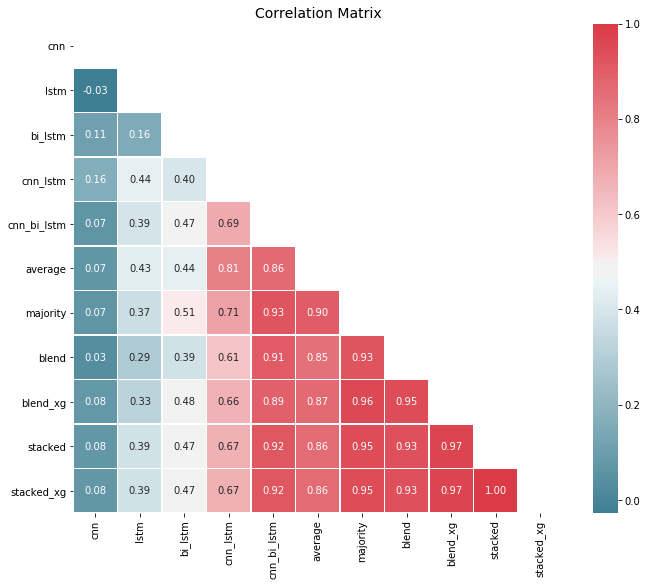

In [207]:
# corrmat(pred_df.corr(), inflate=False,show=False)
# plt.savefig('results/corr_matrix_full.png', bbox_inches='tight')
corrmat(pred_df.corr(), inflate=False)

## saving results

In [208]:
with open('results/ens_result.json','w') as fout:
    json.dump(acc_results,fout,indent=4)